In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

%pip install rasterio
%pip install fiona
%pip install geopandas
%pip install earthpy
%pip install Pillow
%pip install gdal
%pip install tifffile
%pip install imagecodecs

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 30.6 MB/s eta 0:00:00


In [2]:
import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin
from rasterio.coords import disjoint_bounds
from rasterio.windows import from_bounds
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
from rasterio import mask
from rasterio.features import geometry_mask
from rasterio import features
from rasterio.enums import MergeAlg

from rasterio.warp import calculate_default_transform, reproject, Resampling
import pyproj

import geopandas as gpd

from osgeo import gdal
import matplotlib.pyplot as mplot
import numpy as np
from numpy import int16

from PIL import Image

import cv2
import numpy as np
from google.colab.patches import cv2_imshow

import fiona
import geopandas as gpd
from shapely.geometry import box

import os
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.plot as ep

import math

### Load shapes and points and join 'soort'

In [15]:
shp_path = "gdrive/My Drive/Stage/ClassificationData/Shapes/grotestern_shapes_vlucht2.shp"
point_path = "gdrive/My Drive/Stage/ClassificationData/Points/grotestern_shapes_vlucht2_classificatie.shp"

# Load the shapefile
gdf_shapes = gpd.read_file(shp_path)
gdf_points = gpd.read_file(point_path)

print(gdf_points["soort"].unique())

['grote stern - rustend' 'kokmeeuw - rustend' 'kokmeeuw - broedend'
 'grote stern - broedend' 'zwartkopmeeuw - broedend'
 'grote stern - broedend (opgevlogen)' 'canadese gans - broedend'
 'grote stern - dood' 'visdief - broedend' 'visdief - rustend'
 'zwartkopmeeuw - rustend' 'anders']


In [17]:
# Perform spatial join (points that do not overlap with a polygon are omitted)
merged = gpd.sjoin(gdf_shapes, gdf_points, how='left', op='contains')

print(merged["soort"].unique())

['grote stern - rustend' 'kokmeeuw - rustend' 'kokmeeuw - broedend'
 'grote stern - broedend' nan 'zwartkopmeeuw - broedend'
 'grote stern - broedend (opgevlogen)' 'grote stern - dood']


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [20]:
# Remove "-..." from string (broedend, rustend, etc.)
# Remove masks where soort is 'nan'

merged["soort"] = merged["soort"].str.split(" - ").str[0]
merged = merged.dropna(subset=['soort'])

print(merged["soort"].unique())

['grote stern' 'kokmeeuw' 'zwartkopmeeuw']


#### Change every soort that is not 'grote stern' into 'anders' (?)

In [22]:
# Update 'soort' column where it is not 'grote stern'
# merged.loc[merged['soort'] != 'grote stern', 'soort'] = 'anders'

# print(merged["soort"].unique())

## Not necessary as you can specify later

['grote stern' 'anders']


In [23]:
## If you want to save the created shapefile:

# Define the file path and name for the output shapefile
output_path = "gdrive/My Drive/Stage/ClassificationData/Shapes/ShapesWithSoort/grotestern_shapes_vlucht2_soort.shp"

# Write the GeoDataFrame to a shapefile
merged.to_file(output_path)

<ipython-input-23-c7adb79f5f4f>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged.to_file(output_path)


## Convert into raster

In [ ]:
# Load the shapefile
gdf = gpd.read_file(output_path)

# Display the modified GeoDataFrame
gdf

In [28]:
# Raster paths
raster_path = "gdrive/My Drive/Stage/ClassificationData/Rasters/grotestern_vlucht2.tif"
repr_raster_path = "gdrive/My Drive/Stage/ClassificationData/Rasters/Reprojected/grotestern_shapes_vlucht2.tif"
shape_raster_path = "gdrive/My Drive/Stage/ClassificationData/ShapeRasters/grotestern_shapes_vlucht2.tif" # output path

with rasterio.open(raster_path) as src:

    # Get the CRS of the shapefile
    target_crs = gdf.crs

    # Reproject the raster to match the CRS of the shapefile
    transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(repr_raster_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )

        dst = rasterio.open(repr_raster_path)

        # Generate a mask based on the polygons (with value 1 is 'grote stern', value 2 is 'anders')
        mask1 = geometry_mask(gdf[gdf['soort'] == 'grote stern'].geometry, out_shape=dst.shape, transform=dst.transform, invert=True)
        mask2 = geometry_mask(gdf[gdf['soort'] != 'grote stern'].geometry, out_shape=dst.shape, transform=dst.transform, invert=True)

        # Create a new array filled with zeros
        new_array = np.zeros_like(dst.read(1))

        # Set values to 1 or 2 where the polygons are present
        new_array[mask1] = 1
        new_array[mask2] = 2

        # Save the new raster
        profile = dst.profile
        profile.update(count=1, dtype='uint8', nodata=None)  # Remove nodata value
        with rasterio.open(shape_raster_path, 'w', **profile) as newr:
            newr.write(new_array.astype('uint8'), 1)


### Tile

In [32]:
# Convert rasters to images
# Tile images

# Save tiles in lists
raster_tiles = []
mask_tiles = []

# Load in GDAL
raster_data_set = gdal.Open(repr_raster_path)
mask_data_set = gdal.Open(shape_raster_path)

# Convert to array image
raster_band_1 = raster_data_set.GetRasterBand(1) # red channel
raster_band_2 = raster_data_set.GetRasterBand(2) # green channel
raster_band_3 = raster_data_set.GetRasterBand(3) # blue channel
mask_band_1 = mask_data_set.GetRasterBand(1) # first/only channel

# Convert to array image
raster_b1 = raster_band_1.ReadAsArray()
raster_b2 = raster_band_2.ReadAsArray()
raster_b3 = raster_band_3.ReadAsArray()
mask_b1 = mask_band_1.ReadAsArray()

# Stack to image
raster_img = np.dstack((raster_b1, raster_b2, raster_b3))
mask_img = np.dstack((mask_b1))
mask_img = mask_img[0].T # Transpose because axis was inverted (why?)

# WxH tile pixel size
W = 100
H = 100

# Split in to M and N tiles
ortho_raster_tiles = [raster_img[x:x+W,y:y+H] for x in range(0,raster_img.shape[0],W) for y in range(0,raster_img.shape[1],H)]
ortho_mask_tiles = [mask_img[x:x+W,y:y+H] for x in range(0,mask_img.shape[0],W) for y in range(0,mask_img.shape[1],H)]

# Save into larger list
raster_tiles = raster_tiles + ortho_raster_tiles
mask_tiles = mask_tiles + ortho_mask_tiles

print("Total tiles:", len(raster_tiles))

Total tiles: 49098


#### Extra: filter/remove tiles with no birds and/or NoData

In [271]:
import random

# Remove tiles with NoData (black borders)
for i in range(len(raster_tiles)):

  # Value 0 = black (but sometimes < 0  or > 256)
  if (raster_tiles[i] == 0).any() or (raster_tiles[i] < 0).any() or (raster_tiles[i] > 256).any():
    raster_tiles[i] = None
    mask_tiles[i] = None

# Filter
raster_tiles = [tile for tile in raster_tiles if tile is not None]
mask_tiles = [tile for tile in mask_tiles if tile is not None]

# Filter based on tiles where there are no masks (birds)
bird_raster_tiles = []
bird_mask_tiles = []
no_bird_raster_tiles = []
no_bird_mask_tiles = []

for i in range(len(raster_tiles)):

  mask_tile_img = mask_tiles[i].copy()
  contours, _ = cv2.findContours(mask_tile_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if contours == ():
    no_bird_raster_tiles.append(raster_tiles[i])
    no_bird_mask_tiles.append(mask_tiles[i])

  else:
    bird_raster_tiles.append(raster_tiles[i])
    bird_mask_tiles.append(mask_tiles[i])

# Filter a percentage of the no bird tiles (to reduce dataset)
remove_count = len(no_bird_raster_tiles) * 9 // 10  # Keep 10%
indices_to_remove = random.sample(range(len(no_bird_raster_tiles)), remove_count)
no_bird_raster_tiles = [item for i, item in enumerate(no_bird_raster_tiles) if i not in indices_to_remove]
no_bird_mask_tiles = [item for i, item in enumerate(no_bird_mask_tiles) if i not in indices_to_remove]

# Concat and shuffle
raster_tiles = bird_raster_tiles + no_bird_raster_tiles
mask_tiles = bird_mask_tiles + no_bird_mask_tiles

def shuffle_similarly(list1, list2):
    combined = list(zip(list1, list2))
    random.shuffle(combined)
    shuffled_list1, shuffled_list2 = zip(*combined)
    return list(shuffled_list1), list(shuffled_list2)

raster_tiles, mask_tiles = shuffle_similarly(raster_tiles, mask_tiles)

print("After filtering", len(raster_tiles), "tiles")

# If too many, use only certain fraction
raster_tiles = raster_tiles[:int(len(raster_tiles) * 0.1)]
mask_tiles = mask_tiles[:int(len(mask_tiles) * 0.1)]

print("Using", len(raster_tiles), "tiles")


After filtering 5171 tiles
Using 517 tiles


432
[0 1 2]


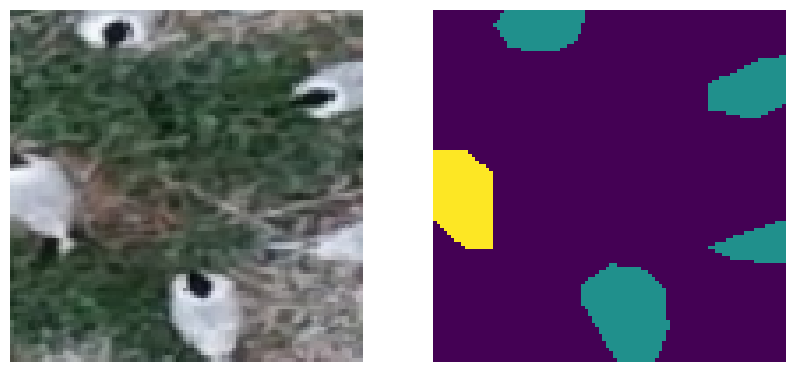

In [367]:
# Check if raster and mask tiles correspond / make sense
import random

# Create a figure with two subplots arranged in a 1x2 grid
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# See random tile
tile_numb = random.randint(0, len(raster_tiles)-1)
print(tile_numb)

# Plot the images
axs[0].imshow(raster_tiles[tile_numb].astype(np.uint8))
axs[0].axis('off')  # Turn off axis labels and ticks
axs[1].imshow(mask_tiles[tile_numb].astype(np.uint8))
axs[1].axis('off')

# Print unique mask values (soorten)
unique_values_mask = np.unique(mask_tiles[tile_numb])
print(unique_values_mask)

# Colours are not specific to one class (e.g., yellow can mean class A in image 1, class B in image 2)

## Write images, masks and annotations to file

In [ ]:
# For each tile, write to file and create annotations

# Out paths
out_img_path = "gdrive/My Drive/Stage/ClassificationData/Ready/Images/"
out_mask_path = "gdrive/My Drive/Stage/ClassificationData/Ready/Masks/"
out_anno_path = "gdrive/My Drive/Stage/ClassificationData/Ready/Annotations/"

for i in range(len(raster_tiles)):

  # Output path
  out_img = out_img_path + "img" + str(i+1) + ".png"
  out_mask = out_mask_path + "mask" + str(i+1) + ".png"
  out_ann = out_anno_path + "annotation" + str(i+1) + ".txt"

  # Save images to file
  plt.imsave(out_img, raster_tiles[i].astype(np.uint8), cmap='gray', format='png') # Convert to uint8
  plt.imsave(out_mask, mask_tiles[i].astype(np.uint8), cmap='gray', format='png')

  # Calculate boxes from mask
  mask_tile_img = mask_tiles[i].copy()
  contours, _ = cv2.findContours(mask_tile_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  bird_labels = []  # List to store bird labels corresponding to each contour

  for contour in contours:
    # Find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Extract the region of interest (ROI)
    roi = mask_tile_img[y:y+h, x:x+w]

    # Find the unique values and their counts in the ROI
    unique_values, counts = np.unique(roi, return_counts=True)

    # Exclude 0 from consideration (is background)
    counts = counts[unique_values != 0]
    unique_values = unique_values[unique_values != 0]

    # Get the index of the maximum count (majority value) --> necessary in cases of overlap
    majority_index = np.argmax(counts)

    # Assign the majority value
    bird_label = unique_values[majority_index]
    bird_labels.append(bird_label)

  # Image width and height
  img_colour = Image.open(out_img) # You need to have the colour image somehow (so write image to file first)
  width, height = img_colour.size

  # Class and number of objects
  num_objects = len(contours)

  with open(out_ann, 'w') as f:
      # Write annotation to file
      f.write(f'Image filename : "{out_img}"\n')
      f.write(f'Image size (X x Y) : {width} x {height}\n')
      f.write(f'Database : "BirdsBreeding"\n')
      f.write(f'Objects with ground truth : {num_objects} \n\n')

      # Loop over each bird (if any) and label
      for j, contour in enumerate(contours):
          x, y, w, h = cv2.boundingRect(contour)
          x_min = x
          y_min = y
          x_max = x + w
          y_max = y + h

          if bird_labels[j] == 1:
            class_name = "Grote stern"
          else:
            class_name = "Anders"

          f.write(f'# Details for object {j+1} \n')
          f.write(f'Original label for object {j+1} : "{class_name}" \n')
          f.write(f'Bounding box for object {j+1} : (Xmin, Ymin) - (Xmax, Ymax) : ({x_min}, {y_min}) - ({x_max}, {y_max})\n')
          f.write(f'Pixel mask for object {j+1} : "{out_mask}"\n\n')
